# Capstone Statistical Inference Testing

## Introduction
This script contains the code I used to perform statistical inference on my Capstone AirBnB dataset. I previously cleaned the data during the Data Wrangling step, and merged it with relevant Yelp data. Then I created visualizations showing some distributions and relationships between variables as a first step in the Exploratory Data Analysis process. The next EDA step is to perform statistical tests to dive deeper into those relationships. 

Questions I plan to answer:

 - Does Price follow a normal distribution? What if I convert to a log scale? 
 - How correlated are Beds, Bedrooms, Bathrooms, and Accomodates with Price? What about their correlation with Reviews per Month? 
 - Are Price and Reviews per Month correlated? 
 - For hosts that respond 100% of the time, are any of the response time groupings more related to price than the others? What about Reviews per Month? 
 - For each Amenity, how does it impact Price/Reviews per Month (using t-tests against the rest of the listings that don't have that amenity). 
 - For each Property Type, how does it impact Price/Reviews per Month? 
 - Using the Yelp data, how are number of businesses, number of reviews, and avg. star rating correlated with Price/Reviews per Month? 
 - Using the Yelp data, is there a significant Price difference between listings with no businesses w/in .1 mile and those that do? What about between those that have no businesses w/in .5 mile and those that do? Same for Reviews per Month.
 
## Import packages, load data

In [12]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from statsmodels.stats.weightstats import ztest
#allow all columns to be viewed:
pd.set_option('display.max_columns', None)
import datetime as dt

In [2]:
current_path = % pwd
#If current_path is in Scripts folder, 
#go up one level so we can open the data folder
if (current_path.rsplit('\\', 1)[1] == 'Scripts'):
    % cd ..

D:\Coding Projects\Springboard\Springboard_Projects\Capstone


In [3]:
#Import data

#Read in AirBnB dataset that has been merged with summarized Yelp information:
#... (number of businesses, total reviews, and average star rating for businesses w/in .1 and .5 miles)
path1='../Capstone/Data/abb_merged.csv'
abb = pd.read_csv(path1)

print(abb.shape)
abb.head()

(16015, 239)


,id,listing_url,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,neighborhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,instant_bookable,cancellation_policy,reviews_per_month,square_feet_notNA,monthly_price_notNA,weekly_price_notNA,bathrooms_notNA,beds_notNA,bedrooms_notNA,security_deposit_notNA,cleaning_fee_notNA,host_response_rate_notNA,reviews_per_month_notNA,neighbourhood_notNA,host_neighbourhood_notNA,neighbourhood_cleansed_notNA,host_response_time_notNA,host_is_superhost_notNA,has_Wifi,has_Heating,has_Essentials,has_Kitchen,has_Smoke_detector,has_Air_conditioning,has_Hangers,has_Washer,has_Dryer,has_Shampoo,has_Carbon_monoxide_detector,has_Laptop_friendly_workspace,has_TV,has_Hair_dryer,has_Iron,has_Hot_water,has_Fire_extinguisher,has_Familykid_friendly,has_Elevator,has_Free_parking_on_premises,has_First_aid_kit,has_Refrigerator,has_Internet,has_Dishes_and_silverware,has_Gym,has_Microwave,has_Stove,has_Self_check-in,has_Oven,has_Bed_linens,has_Cooking_basics,has_Lock_on_bedroom_door,has_Long_term_stays_allowed,has_Private_entrance,has_Coffee_maker,has_Cable_TV,has_Step-free_access,has_Extra_pillows_and_blankets,has_Dishwasher,has_translation_missing:_en.hosting_amenity_50,has_Paid_parking_off_premises,has_Pool,has_Luggage_dropoff_allowed,has_Patio_or_balcony,has_Safety_card,has_translation_missing:_en.hosting_amenity_49,has_Hot_tub,has_Host_greets_you,has_Lockbox,has_24-hour_check-in,has_Pets_allowed,has_Private_living_room,has_Paid_parking_on_premises,has_Breakfast,has_Bathtub,has_Wide_doorway,has_Buzzerwireless_intercom,has_Garden_or_backyard,has_Indoor_fireplace,has_Keypad,has_Free_street_parking,has_Other,has_Wheelchair_accessible,has_Doorman,has_Pets_live_on_this_property,has_Well-lit_path_to_entrance,has_BBQ_grill,has_Ethernet_connection,has_Single_level_home,has_Wide_hallway_clearance,has_Room-darkening_shades,has_Flat_path_to_front_door,has_Smoking_allowed,has_Children’s_books_and_toys,has_Wide_clearance_to_bed,has_Building_staff,has_Smart_lock,has_Wide_entryway,has_High_chair,has_Cleaning_before_checkout,has_Pack_’n_Playtravel_crib,has_Dog(s),has_Accessible-height_bed,has_Cat(s),has_Suitable_for_events,has_Accessible-height_toilet,has_Lake_access,has_Waterfront,has_Crib,has_Handheld_shower_head,has_Children’s_dinnerware,has_Disabled_parking_spot,has_Game_console,has__toilet,has_Wide_clearance_to_shower,has_Pocket_wifi,has_Babysitter_recommendations,has_Full_kitchen,has_Outlet_covers,has_Stair_gates,has_Baby_bath,has_Hot_water_kettle,has_Window_guards,has_Bathroom_essentials,has_Bedroom_comforts,has_Changing_table,has_Toilet_paper,has_Bath_towel,has_Body_soap,has_EV_charger,has_Beachfront,has_Fireplace_guards,has_Netflix,has_Other_pet(s),has_Roll-in_shower,has_,has_Beach_essentials,has_Smart_TV,has_Baby_monitor,has_Fixed_grab_bars_for_shower,has_Breakfast_table,has_Walk-in_shower,has_Convection_oven,has_Outdoor_seating,has_Sound_system,has_Bathtub_with_bath_chair,has_Rain_shower,has_Balcony,has_Pillow-top_mattress,has_Table_corner_guards,has_Soaking_tub,has_Formal_dining_area,has_En_suite_bathroom,has_Memory_foam_mattress,has_Terrace,has_Central_air_conditioning,has_Shower_chair,has_Espresso_machine,has_Firm_mattress,has_Gas_oven,has_Ceiling_fan,has_Heated_floors,has_Fixed_grab_bars_for_toilet,has_DVD_player,has_Exercise_equipment,has_Printer,has_Outdoor_parking,has_Private_bathroom,has_Shared_gym,has_Day_bed,has_HBO_GO,has_Kitchenette,has_Murphy_bed,has_Amazon_Echo,has_Shared_pool,has_Warming_drawer,has_Ski_inSki_out,has_Fire_pit,has_Mini_fridge,has_Pool_with_pool_hoist,has_Sauna,has_Heated_towel_rack,has_Electric_profiling_bed,has_High-resolution_computer_monitor,has_Wine_cooler,has_Air_purifier,has_Ground_floor_access,has_Shared_hot_tub,has_Jetted

## Drop Unnecessary Variables

First, I will drop variables that I have decided are not worth further analysis. These include the listing URL, the host neighborhood (I have already created a derived variable that checks if the host lives in their listing neighborhood), and the amenities (I have created flag variables for each amenity). 

In [4]:
#Drop variables not needed for analysis
drop_cols = ['listing_url', 'host_neighbourhood', 'neighbourhood_cleansed', 'amenities', 'calendar_updated', 'latitude', 'longitude']
abb.drop(columns=drop_cols, axis=1, inplace=True)

In [5]:
abb.shape

(16015, 232)

## Statistical Tests

### Test 1 - Normality of Price/Log Price
My primary goal with this project is to predict the Price of AirBnB listings, so first I will example that outcome variable. 

First I will use the Kolmogorov-Smirnov test to check if the distribution of Price is normal. I suspect I will find that price is not normally distributed, because visualizing it shows a peak at the left or lower-priced end of the range, with a long tail to the right or high-priced end. 

The null hypothesis for this test is that Price follows a normal distribution. The alternate hypothesis is that it has any other distribution. 

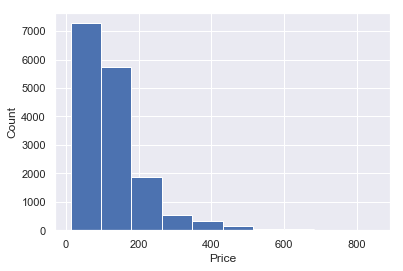

In [6]:
#As a reminder, here is what the plot of price distribution looks like.
plt.hist(abb.price, bins=10)
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

In [7]:
#generate summary statistics
price_mean = np.mean(abb.price)
price_std = np.std(abb.price)

test_stat = scipy.stats.kstest(abb['price'], 'norm', args=(price_mean, price_std))
test_stat

KstestResult(statistic=0.14900645034332038, pvalue=2.80763205512359e-309)

The p-value returned is extremely small, 2.81e-309, therefore we can reject the null hypothesis that Price follows a normal distribution. Next I will check log of price to see if it is normal. If so it would be more useful for statistical inference and modeling. 

In [8]:
abb['log_price'] = np.log(abb.price)

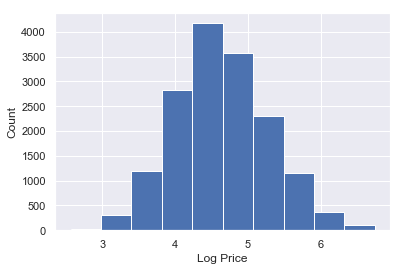

In [9]:
plt.hist(abb.log_price, bins=10)
plt.xlabel('Log Price')
plt.ylabel('Count')
plt.show()

From the histogram alone, log_price appears much more normally distributed compared to the original price variable. I will check again using the K-S test.

In [10]:
log_price_mean = np.mean(abb.log_price)
log_price_std = np.std(abb.log_price)

test_stat = scipy.stats.kstest(abb['log_price'], 'norm', args=(log_price_mean, log_price_std))
test_stat

KstestResult(statistic=0.037374718910779425, pvalue=7.412111228977069e-20)

Interestingly, the log of price still has a very low p-value from the K-S test. At 7.41e-20 it is higher than the p-value achieved by the original price variable, but it is still low enough that we must reject the null hypothesis that log price follows a normal distribution. However I will still use it for my statistical tests to follow. 

### Test 2 - Check the distribution of utilization rate

My secondary goal is to predict the utilization rate of bookings, so I will test it's distribution next. First I need to derive the utilization rate. The process is described on pages 49-51 in the "Analysis of the impact of short-term rentals on housing" report from San Francisco's Budget and Legislative Office. The document is available here: https://sfbos.org/sites/default/files/FileCenter/Documents/52601-BLA.ShortTermRentals.051315.pdf

I recommend reading the pages cited above to understand the full process of calculating the utilzation rate, but this section summarizes the model I will use:

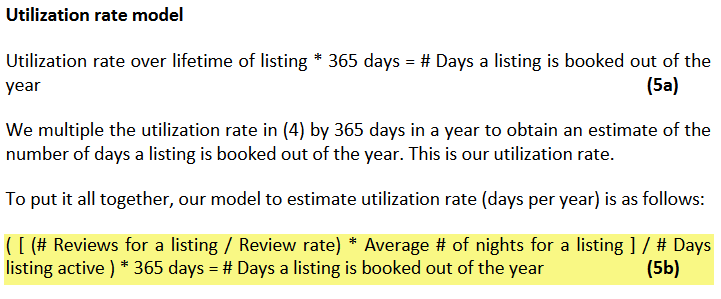

Before I begin, I need to bring back in a handful of variables I previously dropped from my AirBnB dataset. I came to this model later in my analysis after I had dropped these variables thinking they were unnecessary. I will load my original, untransformed dataset now to calculate utilization rate, then merge the rate back to my cleaned dataframe. 

In [32]:
#Read in AirBnB listing data, raw version before any transformations
path='../Capstone/Data/listings.csv'
abb_list = pd.read_csv(path)

In [86]:
#Set apparent review rate, the number of guests that actually leave a review. 
#Air BnB says this is 72%, but independent analyses have placed it closer to 30%. 
#Inside AirBnB uses 50% in their own analyses to split the difference, so I will use their rate.
app_review_rate = .5

#Days listing is active
#Calculated as Date of Last Review - Date Host Joined
abb_list['Days_Active'] = pd.to_datetime(abb_list['last_review']) - pd.to_datetime(abb_list['host_since'])

#Convert from delta to integer datatype, leaving NaNs as is
abb_list['Days_Active'] = abb_list['Days_Active'].astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)


In [105]:
#Calculate # reviews per average booked nights
# (# Reviews for a listing / Review Rate) * Average # nights for a listing
# Avg. # of nights for a listing is estimated as 5.1 by SF Travel per above citation, 
#... but I have decided to use the Minimum Nights value instead, unless it goes over 5.1. 
#This may underestimate utilization, but prevents having listings go over 100% utilization.
abb_list['Nights_Per_Booking'] = np.where(abb_list['minimum_nights'] > 5.1, 5.1, abb_list['minimum_nights'])
        
abb_list['Est_Nights_Booked'] = (abb_list['number_of_reviews'] / app_review_rate) * abb_list['Nights_Per_Booking']

In [106]:
#Utilization rate over lifetime of listing
# Estimated # Nights Booked / # Days Listing Active
abb_list['Lifetime_Utilization'] = abb_list['Est_Nights_Booked'] / abb_list['Days_Active']

In [107]:
#Utilization Rate, or the average number of days a listing is booked in a year
# Utilization rate over life of listing * 365 days
abb_list['Utilization_Rate'] = abb_list['Lifetime_Utilization'] * 365

In [108]:
#Drop everything but ID and Utilization Rate, then merge with abb dataset
abb_util_rate = abb_list[['id', 'Utilization_Rate']]
#Check for null values
abb_util_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17542 entries, 0 to 17541
Data columns (total 2 columns):
id                  17542 non-null int64
Utilization_Rate    14314 non-null float64
dtypes: float64(1), int64(1)
memory usage: 274.2 KB


In [109]:
abb_util_rate.describe()

,id,Utilization_Rate
count,1.754200e+04,1.431400e+04
mean,1.683533e+07,inf
std,7.578725e+06,NaN
min,1.419000e+03,2.565004e-01
25%,1.125480e+07,7.577225e+00
50%,1.847656e+07,2.339890e+01
75%,2.302324e+07,6.463051e+01
max,2.758201e+07,inf


There are about 3000 missing values for Utilization Rate. This is caused when the listing has no reviews. Therefore I will assume the listing has never been booked and set the utilization rate to 0. 

There was also a single infinite value. The cell below inspects this record. This was caused by the listing being posted on 6/30/16 and having it's first and last review post on the same day, resulting in a value of 0 for Days_Active, causing a divide by zero in the utilization rate formula. This seems suspicious (being reviewed on the same day the listing is made active) so I will remove this record.

In [92]:
abb_list[abb_util_rate.Utilization_Rate == float('inf')].head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,Days_Active,Est_Nights_Booked,Lifetime_Utilization,Utilization_Rate
5620,13784364,https://www.airbnb.com/rooms/13784364,20180808031137,2018-08-08,Cozy Private Room in the heart of Downtown Tor...,"My place is close to Yonge-Dundas Square, Eato...",NaN,"My place is close to Yonge-Dundas Square, Eato...",none,NaN,NaN,NaN,NaN,NaN,"- No drugs, no downloading movies/tv shows, sm...",NaN,NaN,https://a0.muscache.com/im/pictures/6ebb0363-5...,NaN,80954801,https://www.airbnb.com/users/show/80954801,Cassandra,2016-06-30,"Toronto, Ontario, Canada",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/49d2461d-0...,https://a0.muscache.com/im/pictures/49d2461d-0...,NaN,1.0,1.0,"['email', 'phone']",t,f,"Toronto, ON, Canada",Downtown Toronto,Bay Street Corridor,NaN,Toronto,ON,NaN,Toronto,"Toronto, Canada",CA,Canada,43.655821,-79.383061,f,Condominium,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Gym,Elevat...",NaN,$72.00,NaN,NaN,$260.00,$20.00,1,$0.00,1,5,25 months ago,t,0,0,0,0,2018-08-08,1,2016-06-30,2016-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,f,flexible,f,f,1,0.04,0.0,2.0,inf,inf


In [110]:
#Remove index 5620 from abb_util_rate
abb_util_rate = abb_util_rate.drop(5620)

In [ ]:
#Remove index 5620 from abb
abb = abb.drop(5620)

In [111]:
#Replace missing Utilization_Rate with 0
abb_util_rate.Utilization_Rate = abb_util_rate.Utilization_Rate.fillna(0)

In [112]:
#Merge Utilization Rate back into abb dataset
abb = pd.merge(abb, abb_util_rate, on='id')

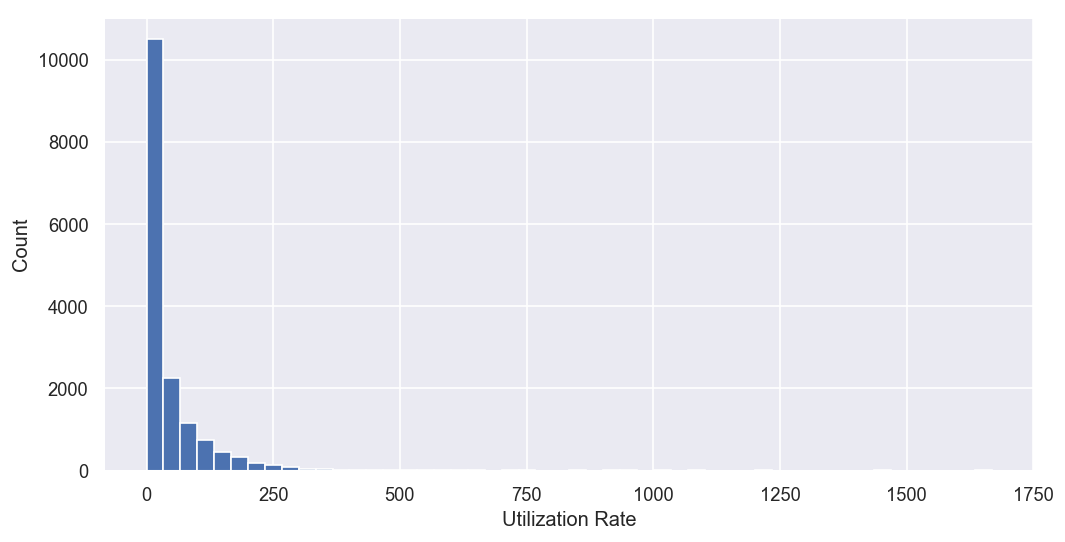

In [121]:
#Here is the distribution of Utilization Rate
fig=plt.figure(figsize=(10, 5), dpi=120)
plt.hist(abb['Utilization_Rate'], bins=50)
plt.xlabel('Utilization Rate')
plt.ylabel('Count')
plt.show()

In [123]:
abb['Log_Utilization_Rate'] = np.where(abb.Utilization_Rate > 0, np.log(abb.Utilization_Rate), 0)

C:\Users\jshka\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [124]:
abb['Log_Utilization_Rate'].describe()

count    16013.000000
mean         2.520349
std          1.767983
min         -1.360625
25%          0.937053
50%          2.723739
75%          3.972006
max          7.419723
Name: Log_Utilization_Rate, dtype: float64

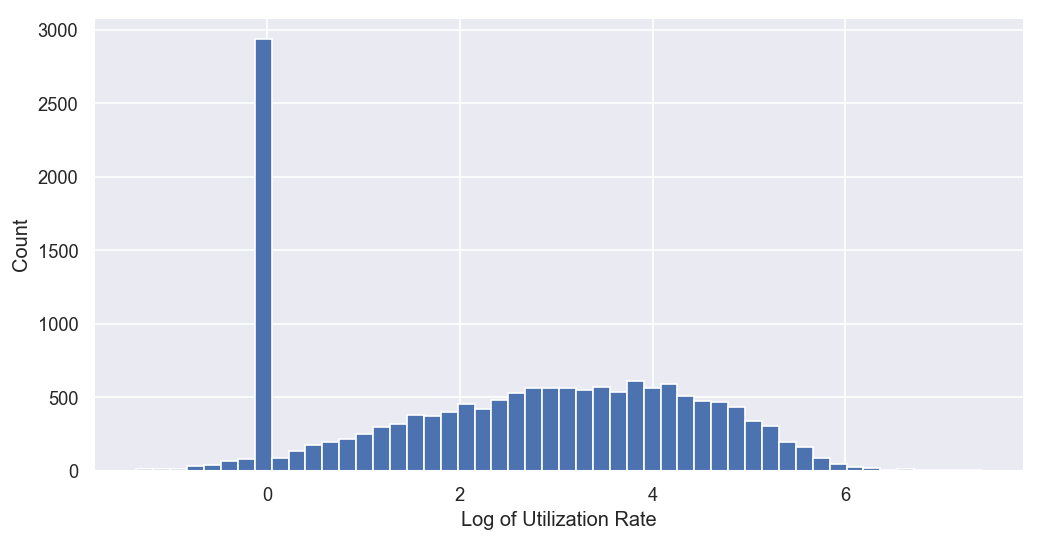

In [125]:
#Here is the distribution of Utilization Rate
fig=plt.figure(figsize=(10, 5), dpi=120)
plt.hist(abb['Log_Utilization_Rate'], bins=50)
plt.xlabel('Log of Utilization Rate')
plt.ylabel('Count')
plt.show()

In [127]:
#Run KS Test to check if Normal (likely not due to spike at 0)
log_util_mean = np.mean(abb.Log_Utilization_Rate)
log_util_std = np.std(abb.Log_Utilization_Rate)

test_stat_util = scipy.stats.kstest(abb['Log_Utilization_Rate'], 'norm', args=(log_util_mean, log_util_std))
test_stat_util

KstestResult(statistic=0.12034710481087384, pvalue=7.164559179980667e-202)

As I suspected the p-value is very small, 7.16e-202, so I will reject the null hypothesis that Log Utilization Rate is normally distributed.

### Test 3 - How do Beds, Bedrooms, Bathrooms, Accommodates correlate with Price and Utilization?

In [131]:
#Calculate correlation for beds and price
beds_coef, beds_p_value = scipy.stats.pearsonr(abb.log_price, abb.beds)
print("Price/Beds Pearson Correlation Coefficient: ", beds_coef, "and a P-value of:", beds_p_value)

#Calculate correlation for bedrooms and price
brooms_coef, brooms_p_value = scipy.stats.pearsonr(abb.log_price, abb.bedrooms)
print("Price/Bedrooms Pearson Correlation Coefficient: ", brooms_coef, "and a P-value of:", brooms_p_value)

#Calculate correlation for bathrooms and price
bath_coef, bath_p_value = scipy.stats.pearsonr(abb.log_price, abb.bathrooms)
print("Price/Bathrooms Pearson Correlation Coefficient: ", bath_coef, "and a P-value of:", bath_p_value)


#Calculate correlation for accomodates and price
acc_coef, acc_p_value = scipy.stats.pearsonr(abb.log_price, abb.accommodates)
print("Price/Accommodates Pearson Correlation Coefficient: ", acc_coef, "and a P-value of:", acc_p_value)

Price/Beds Pearson Correlation Coefficient:  0.474849647017861 and a P-value of: 0.0
Price/Bedrooms Pearson Correlation Coefficient:  0.43473749216838437 and a P-value of: 0.0
Price/Bathrooms Pearson Correlation Coefficient:  0.2990885313787908 and a P-value of: 0.0
Price/Accommodates Pearson Correlation Coefficient:  0.5880624352376508 and a P-value of: 0.0


In [132]:
#Calculate correlation for beds and price
beds_coef2, beds_p_value2 = scipy.stats.pearsonr(abb.Log_Utilization_Rate, abb.beds)
print("Utilization/Beds Pearson Correlation Coefficient: ", beds_coef2, "and a P-value of:", beds_p_value2)

#Calculate correlation for bedrooms and price
brooms_coef2, brooms_p_value2 = scipy.stats.pearsonr(abb.Log_Utilization_Rate, abb.bedrooms)
print("Utilization/Bedrooms Pearson Correlation Coefficient: ", brooms_coef2, "and a P-value of:", brooms_p_value2)

#Calculate correlation for bathrooms and price
bath_coef2, bath_p_value2 = scipy.stats.pearsonr(abb.Log_Utilization_Rate, abb.bathrooms)
print("Utilization/Bathrooms Pearson Correlation Coefficient: ", bath_coef2, "and a P-value of:", bath_p_value2)


#Calculate correlation for accomodates and price
acc_coef2, acc_p_value2 = scipy.stats.pearsonr(abb.Log_Utilization_Rate, abb.accommodates)
print("Utilization/Accommodates Pearson Correlation Coefficient: ", acc_coef2, "and a P-value of:", acc_p_value2)

Utilization/Beds Pearson Correlation Coefficient:  0.07133621137242882 and a P-value of: 1.5975142983817026e-19
Utilization/Bedrooms Pearson Correlation Coefficient:  -0.0038710054143790197 and a P-value of: 0.6242681895088642
Utilization/Bathrooms Pearson Correlation Coefficient:  -0.03613249930725774 and a P-value of: 4.797982023382189e-06
Utilization/Accommodates Pearson Correlation Coefficient:  0.10317307277317701 and a P-value of: 3.77091817861236e-39


### Test 4 - Are Price and Utilization correlated?

In [133]:
p_u_coef, p_u_value = scipy.stats.pearsonr(abb.log_price, abb.Log_Utilization_Rate)
print("Price/Utilization Pearson Correlation Coefficient: ", p_u_coef, "and a P-value of:", p_u_value)

Price/Utilization Pearson Correlation Coefficient:  -0.036929093119244624 and a P-value of: 2.9491675621646644e-06


### Test 5 - How do different response time groupings relate to price, for hosts that respond 100% of the time?

In [21]:
#create subset of AirBnB dataset with just hosts that respond 100% of the time
abb_100_response = abb[abb['host_response_rate'] == 100]
abb_100_response.host_response_time.value_counts()

within an hour        6996
within a few hours    1711
within a day           614
Name: host_response_time, dtype: int64

In [29]:
print("Mean price for hosts responding within an hour: ", np.mean(hrt_1))
print("Mean price for hosts responding within a few hours: ", np.mean(hrt_2))
print("Mean price for hosts responding within a day: ", np.mean(hrt_3))

Mean price for hosts responding within an hour:  128.26643796455116
Mean price for hosts responding within a few hours:  121.88194038573933
Mean price for hosts responding within a day:  131.5114006514658


In [30]:
hrt_1 = abb_100_response[abb_100_response['host_response_time']=='within an hour']['price']
hrt_2 = abb_100_response[abb_100_response['host_response_time']=='within a few hours']['price']
hrt_3 = abb_100_response[abb_100_response['host_response_time']=='within a day']['price']

In [31]:
stats.f_oneway(hrt_1, hrt_2, hrt_3)

F_onewayResult(statistic=3.930655213433043, pvalue=0.019663364219449624)

### Test 6 - Compare significance of each amenity type on price


In [172]:
#Drop the has_amenity columns that have fewer than 10 listings with that amenity
for col in abb.columns:
    if 'has_' in col:
        if abb[col].sum() < 10:
            abb = abb.drop([col], axis=1)

In [192]:
abb = abb.drop(['has_'], axis=1)

In [196]:
amenity_stats = pd.DataFrame()

for col in abb.columns:
    if 'has_' in col:
        df = pd.DataFrame()
        statistic, pvalue = stats.ttest_ind(abb[abb[col] == True]['price'], 
                                            abb[abb[col] == False]['price'])
        pvalue = "{:.8f}".format(float(pvalue))
        mean_True = abb[abb[col] == True]['price'].mean()
        mean_False = abb[abb[col] == False]['price'].mean()
        count_has = abb[col].sum()
        
        data = pd.DataFrame({'amenity' : [col], 'stat' : [statistic], 'pvalue' : [pvalue],
                            'mean_True' : [mean_True], 'mean_False' : [mean_False],
                            'count_has' : [count_has], 'mean_diff' : [mean_True - mean_False]})
        
        amenity_stats = amenity_stats.append(data, ignore_index=True)
        
        #print("The statistic for ", col, " is ", statistic, 
        #      ". The p-value is ", pvalue, ". ", abb[col].sum(), "listings have this amenity.")

In [246]:
amenity_stats.sort_values(by=['mean_diff'], ascending=False)

,amenity,stat,pvalue,mean_True,mean_False,count_has,mean_diff
10,has_TV,37.748445,0.00000000,145.075802,85.681721,11319,59.394080
16,has_Cable_TV,22.373607,0.00000000,156.302337,118.196443,3979,38.105894
18,has_Pool,17.463186,0.00000000,159.308599,122.382087,2291,36.926512
15,has_Gym,6.438904,0.00000000,146.955128,126.467666,936,20.487462
0,has_Wifi,2.695300,0.00703986,127.975387,114.587601,15642,13.387786
5,has_Air_conditioning,5.749887,0.00000001,130.361665,120.830022,11483,9.531643
26,has_Doorman,0.573198,0.56651837,135.320000,127.641233,50,7.678767
14,has_Internet,4.353703,0.00001347,132.306467,125.386499,5273,6.919968
23,has_Indoor_fireplace,-0.486592,0.62655427,120.108108,127.682712,37,-7.574603
12,has_Elevator,-4.080994,0.00004506,112.949924,128.296796,659,-15.346871


### Test 7 - Compare Mean Price of Property Types

Before I perform my test, I would like to lump all property types with fewer listings than "Other" into the "Other" category. Here is a look at the property types and their counts:

In [203]:
abb.property_type.value_counts()

Apartment                 5786
House                     4117
Condominium               3592
Townhouse                  756
Guest suite                473
Loft                       389
Bungalow                   364
Serviced apartment         163
Guesthouse                  95
Bed and breakfast           86
Other                       59
Villa                       41
Boutique hotel              29
Hostel                      18
Camper/RV                   10
Boat                         7
Cottage                      5
Cabin                        4
In-law                       3
Aparthotel                   3
Cave                         3
Tiny house                   3
Earth house                  1
Hotel                        1
Castle                       1
Dorm                         1
Casa particular (Cuba)       1
Treehouse                    1
Tent                         1
Name: property_type, dtype: int64

In [219]:
#Convert property types smaller than Other, lumping them in with Other

#Calculate value counts for each type
prop_types = pd.value_counts(abb.property_type)
#Create a boolean mask, False if proportion less than .36 
#...(captures everything under "Other")
mask = (prop_types/prop_types.sum() * 100).lt(.36)

#Change the property types in abb dataframe
abb['property_type'] = np.where(abb['property_type'].isin(prop_types[mask].index),
                               'Other', abb['property_type'])



In [220]:
abb.property_type.value_counts()

Apartment             5786
House                 4117
Condominium           3592
Townhouse              756
Guest suite            473
Loft                   389
Bungalow               364
Other                  192
Serviced apartment     163
Guesthouse              95
Bed and breakfast       86
Name: property_type, dtype: int64

In [239]:
property_stats = pd.DataFrame()
for index, value in abb.property_type.value_counts().iteritems():
    df = pd.DataFrame()
    statistic, pvalue = stats.ttest_ind(abb[abb['property_type'] == index]['price'], 
                                            abb[abb['property_type'] != index]['price'])
    pvalue = "{:.8f}".format(float(pvalue))
    mean_True = abb[abb['property_type'] == index]['price'].mean()
    mean_False = abb[abb['property_type'] != index]['price'].mean()
    count_has = abb[abb['property_type'] == index]['property_type'].count()

    data = pd.DataFrame({'prop_type' : [index], 'stat' : [statistic], 'pvalue' : [pvalue],
                        'mean_True' : [mean_True], 'mean_False' : [mean_False],
                        'count_has' : [count_has], 'mean_diff' : [mean_True - mean_False]})

    property_stats = property_stats.append(data, ignore_index=True)

In [245]:
property_stats.sort_values(by=['mean_diff'], ascending=False)

,prop_type,stat,pvalue,mean_True,mean_False,count_has,mean_diff
8,Serviced apartment,7.575520,0.00000000,183.398773,127.092050,163,56.306723
2,Condominium,24.550107,0.00000000,161.161748,117.978424,3592,43.183325
5,Loft,8.299147,0.00000000,166.892031,126.688556,389,40.203475
10,Bed and breakfast,0.394169,0.69346145,131.674419,127.643561,86,4.030857
3,Townhouse,-2.353052,0.01863205,119.765873,128.056630,756,-8.290757
0,Apartment,-7.826311,0.00000000,119.903215,132.056615,5786,-12.153400
7,Other,-2.225591,0.02605544,112.567708,127.848429,192,-15.280721
1,House,-10.821039,0.00000000,113.967209,132.405851,4117,-18.438642
4,Guest suite,-8.201626,0.00000000,92.602537,128.732432,473,-36.129895
6,Bungalow,-8.030962,0.00000000,88.387363,128.578823,364,-40.191460


### Test 8 - How are Number of Businesses, Number of Reviews, and Avg. Star Rating from Yelp data correlated with Price and Utilization?

#### Price Correlations where businesses w/in .1 mile

In [253]:
#Create DF of listings w/ a business in .1 mile
point_one_listings = abb[abb['yelp_bus_count_1'].notna()]
point_one_listings.shape

(6832, 81)

In [256]:
# Number of businesses in .1 mile against price
coef1, value1 = scipy.stats.pearsonr(point_one_listings.log_price, point_one_listings.yelp_bus_count_1)
print("Price/Bus. w/in .1 mile Pearson Correlation Coefficient: ", coef1, "and a P-value of:", value1)

# Total reviews of businesses in .1 mile against price
coef2, value2 = scipy.stats.pearsonr(point_one_listings.log_price, point_one_listings.yelp_bus_total_reviews_1)
print("Price/Reviews of Bus. w/in .1 mile Pearson Correlation Coefficient: ", coef2, "and a P-value of:", value2)

# Avg. rating of businesses in .1 mile against price
coef3, value3 = scipy.stats.pearsonr(point_one_listings.log_price, point_one_listings.yelp_bus_avg_rating_1)
print("Price/Avg. Rating of Bus. w/in .1 mile Pearson Correlation Coefficient: ", coef3, "and a P-value of:", value3)

Price/Bus. w/in .1 mile Pearson Correlation Coefficient:  0.07233124109838855 and a P-value of: 2.1592308923617647e-09
Price/Reviews of Bus. w/in .1 mile Pearson Correlation Coefficient:  0.08985311837219813 and a P-value of: 1.0023936665577911e-13
Price/Avg. Rating of Bus. w/in .1 mile Pearson Correlation Coefficient:  -0.08098330900462697 and a P-value of: 2.0343452238030033e-11


#### Utilization Correlations where businesses w/in .1 mile

In [257]:
# Number of businesses in .1 mile against utilization
coef4, value4 = scipy.stats.pearsonr(point_one_listings.Log_Utilization_Rate, point_one_listings.yelp_bus_count_1)
print("Util./Bus. w/in .1 mile Pearson Correlation Coefficient: ", coef4, "and a P-value of:", value4)

# Total reviews of businesses in .1 mile against utilization
coef5, value5 = scipy.stats.pearsonr(point_one_listings.Log_Utilization_Rate, point_one_listings.yelp_bus_total_reviews_1)
print("Util./Reviews of Bus. w/in .1 mile Pearson Correlation Coefficient: ", coef5, "and a P-value of:", value5)

# Avg. rating of businesses in .1 mile against utilization
coef6, value6 = scipy.stats.pearsonr(point_one_listings.Log_Utilization_Rate, point_one_listings.yelp_bus_avg_rating_1)
print("Util./Avg. Rating of Bus. w/in .1 mile Pearson Correlation Coefficient: ", coef6, "and a P-value of:", value6)

Util./Bus. w/in .1 mile Pearson Correlation Coefficient:  0.00985073881549244 and a P-value of: 0.4155919170072151
Util./Reviews of Bus. w/in .1 mile Pearson Correlation Coefficient:  0.013888355858453627 and a P-value of: 0.2510511209834639
Util./Avg. Rating of Bus. w/in .1 mile Pearson Correlation Coefficient:  -0.023186695132908934 and a P-value of: 0.05531109703735297


#### Price Correlations where businesses w/in .5 mile

In [259]:
#Create DF of listings w/ a business in .1 mile
point_five_listings = abb[abb['yelp_bus_count_5'].notna()]
point_five_listings.shape

(14219, 81)

In [260]:
# Number of businesses in .5 mile against price
coef7, value7 = scipy.stats.pearsonr(point_five_listings.log_price, point_five_listings.yelp_bus_count_5)
print("Price/Bus. w/in .5 mile Pearson Correlation Coefficient: ", coef7, "and a P-value of:", value7)

# Total reviews of businesses in .5 mile against price
coef8, value8 = scipy.stats.pearsonr(point_five_listings.log_price, point_five_listings.yelp_bus_total_reviews_5)
print("Price/Reviews of Bus. w/in .5 mile Pearson Correlation Coefficient: ", coef8, "and a P-value of:", value8)

# Avg. rating of businesses in .5 mile against price
coef9, value9 = scipy.stats.pearsonr(point_five_listings.log_price, point_five_listings.yelp_bus_avg_rating_5)
print("Price/Avg. Rating of Bus. w/in .5 mile Pearson Correlation Coefficient: ", coef9, "and a P-value of:", value9)

Price/Bus. w/in .5 mile Pearson Correlation Coefficient:  0.23067006559996686 and a P-value of: 4.628714745976835e-171
Price/Reviews of Bus. w/in .5 mile Pearson Correlation Coefficient:  0.23445197248735028 and a P-value of: 8.267801584773236e-177
Price/Avg. Rating of Bus. w/in .5 mile Pearson Correlation Coefficient:  -0.06790880993010719 and a P-value of: 5.217281643786631e-16


#### Utilization Correlations where businesses w/in .5 mile

In [261]:
# Number of businesses in .5 mile against utilization
coef10, value10 = scipy.stats.pearsonr(point_five_listings.Log_Utilization_Rate, point_five_listings.yelp_bus_count_5)
print("Util./Bus. w/in .5 mile Pearson Correlation Coefficient: ", coef10, "and a P-value of:", value10)

# Total reviews of businesses in .5 mile against utilization
coef11, value11 = scipy.stats.pearsonr(point_five_listings.Log_Utilization_Rate, point_five_listings.yelp_bus_total_reviews_5)
print("Util./Reviews of Bus. w/in .5 mile Pearson Correlation Coefficient: ", coef11, "and a P-value of:", value11)

# Avg. rating of businesses in .5 mile against utilization
coef12, value12 = scipy.stats.pearsonr(point_five_listings.Log_Utilization_Rate, point_five_listings.yelp_bus_avg_rating_5)
print("Util./Avg. Rating of Bus. w/in .5 mile Pearson Correlation Coefficient: ", coef12, "and a P-value of:", value12)

Util./Bus. w/in .5 mile Pearson Correlation Coefficient:  0.05005205924983336 and a P-value of: 2.3494053904804306e-09
Util./Reviews of Bus. w/in .5 mile Pearson Correlation Coefficient:  0.05382404638755043 and a P-value of: 1.342693817987952e-10
Util./Avg. Rating of Bus. w/in .5 mile Pearson Correlation Coefficient:  0.00714375064985307 and a P-value of: 0.3943354090818292


### Test 9 -  Is there a significant price difference in listings with no businesses in .1 and .5 miles and those that have them?

In [266]:
point_one_test = stats.ttest_ind(abb[abb['yelp_bus_count_1'].notna()]['price'],
                       abb[abb['yelp_bus_count_1'].isna()]['price'])

print("Listings with at least one business w/in .1 mile charge an average of $", abb[abb['yelp_bus_count_1'].notna()]['price'].mean())
print("Listings that do not have at least one business w/in .1 mile charge an average of $", abb[abb['yelp_bus_count_1'].isna()]['price'].mean())

print(point_one_test)

Listings with at least one business w/in .1 mile charge an average of $ 147.50966042154568
Listings that do not have at least one business w/in .1 mile charge an average of $ 112.89805032131576
Ttest_indResult(statistic=23.28848885941832, pvalue=5.264485625378294e-118)


In [267]:
point_five_test = stats.ttest_ind(abb[abb['yelp_bus_count_5'].notna()]['price'],
                       abb[abb['yelp_bus_count_5'].isna()]['price'])

print("Listings with at least one business w/in .5 mile charge an average of $", abb[abb['yelp_bus_count_5'].notna()]['price'].mean())
print("Listings that do not have at least one business w/in .5 mile charge an average of $", abb[abb['yelp_bus_count_5'].isna()]['price'].mean())

print(point_five_test)

Listings with at least one business w/in .5 mile charge an average of $ 131.03249173640904
Listings that do not have at least one business w/in .5 mile charge an average of $ 100.97658862876254
Ttest_indResult(statistic=12.747798986106021, pvalue=4.854272063863861e-37)
